In [1]:
# IMPORTAÇÃO
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from BorutaShap import BorutaShap

import numpy as np

In [2]:
# Leitura dos arquivos
df = pd.read_excel ('Dataset.xlsx', sheet_name='Dados') # Dados
dic = pd.read_excel ('Dataset.xlsx', sheet_name='Dicionário', usecols=[0,1]).dropna() # Dicionário

# ANÁLISE EXPLORATÓRIA

Buscando valores nulos na base.

In [3]:
df[pd.isnull(df).any(axis=1)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


Buscando colunas que não variam.

In [4]:
df.nunique() > 1

Age                          True
Attrition                    True
BusinessTravel               True
DailyRate                    True
Department                   True
DistanceFromHome             True
Education                    True
EducationField               True
EmployeeCount               False
EmployeeNumber               True
EnvironmentSatisfaction      True
Gender                       True
HourlyRate                   True
JobInvolvement               True
JobLevel                     True
JobRole                      True
JobSatisfaction              True
MaritalStatus                True
MonthlyIncome                True
MonthlyRate                  True
NumCompaniesWorked           True
Over18                      False
OverTime                     True
PercentSalaryHike            True
PerformanceRating            True
RelationshipSatisfaction     True
StandardHours               False
StockOptionLevel             True
TotalWorkingYears            True
TrainingTimesL

Como os campos EmployeeCount, Over18 e StandardHours não variam, os mesmos serão deletados. Além disso, o identificador EmployeeNumber também será excluído

In [5]:
df = df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1)

As classes multi categóricas devem ser transformadas por meio da função dummy_features para classes binárias.

In [6]:
dummy_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole','MaritalStatus']

df = pd.get_dummies(df, prefix=dummy_features, columns=dummy_features)

Algumas variáveis categóricas possuem o formato "Yes" e "No" para representar a classe. Com isso, as mesmas devem ser remapeadas para o formato 1 e 0.

In [7]:
# Tratamento de variáveis categóricas
Attrition_map={'Yes':'1', 'No':'0'}
OverTime_map={'Yes':'1', 'No':'0'}


df = df.replace({'Attrition':Attrition_map, 'OverTime':OverTime_map})

In [28]:
x = df.drop('Attrition', axis=1)
y = df['Attrition']

## Feature selection
O feature selection é importante tanto pelo ponto de vista técnico, por permitir que o dataset possa ser resumido por meio da deleção de features não importantes quanto do ponto de vista do negócio, por permitir explorar e categorizar as características mais importantes do problema.

A biblioteca [BorutaShap](https://pypi.org/project/BorutaShap/) combina tanto o algoritmo de feature selection [Boruta](https://pdfs.semanticscholar.org/ecc2/ca3150dc4d4d8dceedab244114f191e05742.pdf), que usa um modelo de floresta aleatória para pontuar as features, quanto [Shapley Values](https://en.wikipedia.org/wiki/Shapley_value), um artifício da teoria dos jogos que busca pontuar cada feature baseado na sua contribuição/significância em relação ao y do problema.


### Boruta
O Boruta cria as "shadow features", pegando as colunas do dataframe e randomizando as mesmas, criando um dataframe X_boruta, que possui os campos do dataframe X convencionais e as suas "sombras" equivalentes. Depois disso, um modelo de árvore é aplicado a este dataframe resultante e as feature_importances são computadas. Somente serão consideradas variáveis válidas aquelas onde o seu score performar melhor que o maior score das shadow features.

Este processo é feito em uma quantidade suficiente de vezes de forma que o resultado seja o mais independente possível da aleatoriedade de um modelo de árvore.


### Shapley Values
Os shapley values são calculados por meio da interpolação entre os resultados das features, na tentativa de buscar a "importância" de cada valor de cada feature no resultado final (y). Aqui, cada parâmetro ganha uma "recompensa" igual ou superior a sua participação individual.

In [9]:
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=False)
                    
Feature_Selector.fit(X=x, y=y, n_trials=100, sample=False,
            	     train_or_test = 'test', normalize=True,
		             verbose=True)
					
#x = Feature_Selector.Subset()

100%|██████████| 100/100 [08:22<00:00,  5.02s/it]8 attributes confirmed important: ['Age', 'MonthlyIncome', 'DailyRate', 'OverTime', 'EnvironmentSatisfaction', 'YearsAtCompany', 'YearsWithCurrManager', 'TotalWorkingYears']
38 attributes confirmed unimportant: ['Gender_Female', 'JobRole_Laboratory Technician', 'WorkLifeBalance', 'Education', 'PercentSalaryHike', 'BusinessTravel_Travel_Rarely', 'JobRole_Manufacturing Director', 'BusinessTravel_Travel_Frequently', 'Gender_Male', 'EducationField_Other', 'HourlyRate', 'JobLevel', 'JobRole_Research Scientist', 'MaritalStatus_Divorced', 'Department_Sales', 'YearsSinceLastPromotion', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'RelationshipSatisfaction', 'EducationField_Technical Degree', 'EducationField_Life Sciences', 'EducationField_Medical', 'Department_Human Resources', 'MaritalStatus_Married', 'JobInvolvement', 'EducationField_Human Resources', 'YearsInCurrentRole', 'JobRole_Manager', 'MonthlyRate', 'JobRole_Research 

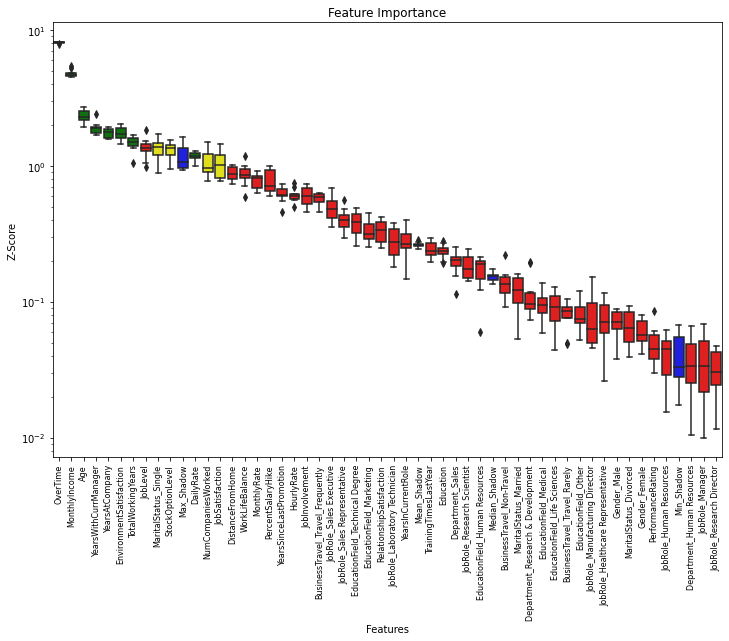

In [10]:
fig = Feature_Selector.plot() # Plot das features mais importantes

In [11]:
# Função para plotar as features por quantil
def continuous(df, feature):
    bins = [df[feature].min(), df[feature].quantile(.25), df[feature].quantile(.5), df[feature].quantile(.75), df[feature].max()]
    
    out=pd.cut(df.query('Attrition=="1"')[feature], bins=bins, include_lowest=True)
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))

    ax.set_xticklabels([str(c)[1:-1].replace(","," até") for c in out.cat.categories])
    ax.get_yaxis().set_visible(False)
    plt.title(f'{feature} VS Attrition')

    plt.savefig(f'resultados/{feature} VS Attrition')

    plt.show()

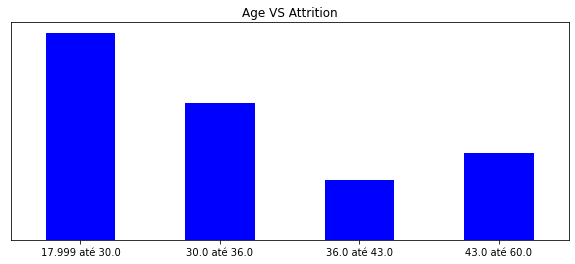

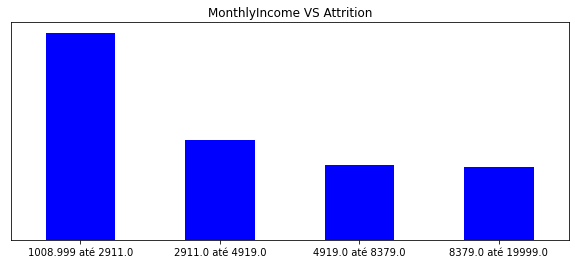

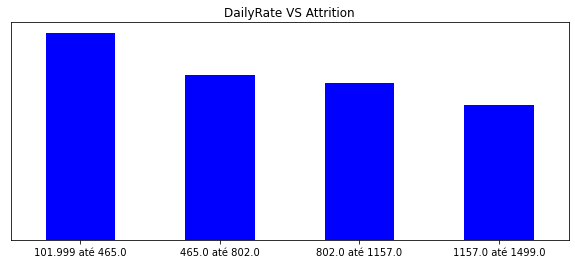

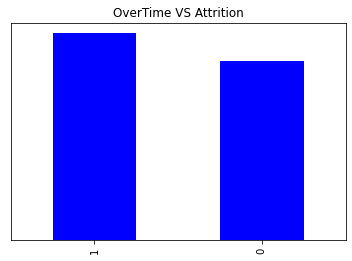

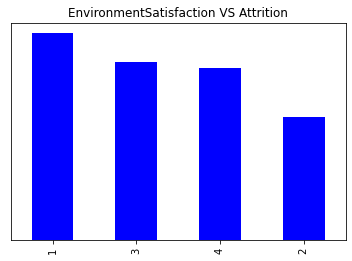

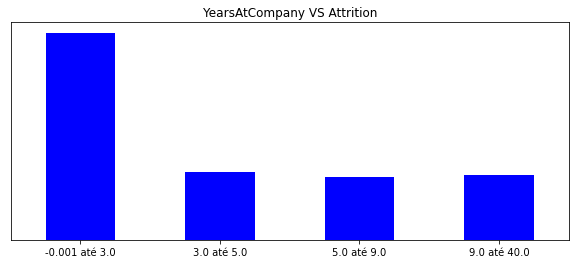

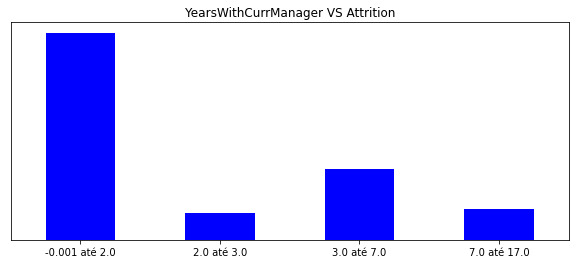

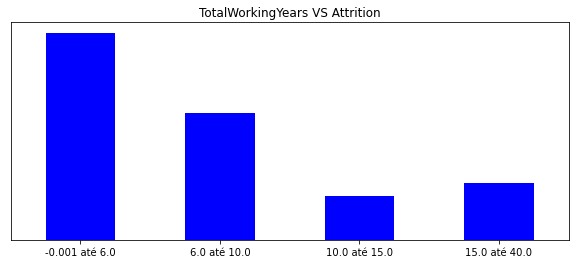

In [12]:
# %% Plot das features mais importantes
for ind in Feature_Selector.Subset().columns:
    # Tenta plotar as features usando a função de quantil
    try: 
        continuous(df, ind)

    # Em caso de erro, é feita uma plotagem simples
    except Exception:
        ax = df.query('Attrition=="1"')[ind].value_counts().plot(kind='bar', color='blue')
        plt.title(f'{ind} VS Attrition')
        ax.get_yaxis().set_visible(False)

        plt.savefig(f'resultados/{ind} VS Attrition')
        plt.show()

# Teste de modelos clássicos
Configuração do tipo da variável y

In [13]:
y = y.astype('int32')

Contagem do balanceamento da base

In [29]:
y.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

Como a base está desbalanceada, será necessário usar uma estratégia de balanceamento, como o [SMOTE](http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html). Este algoritmo escolhe 2 pontos da classe minoritária próximos no espaço amostral do dataset e, em uma linha que conecta os dois, adiciona uma nova amostra à base.

In [31]:
sm = SMOTE(sampling_strategy='auto')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
y_train.value_counts()

0    817
1    167
Name: Attrition, dtype: int64

In [32]:
X_res, y_res = sm.fit_resample(X_train, y_train)

In [33]:
# Realizando uma nova contagem para avaliar a nova base
y_res.value_counts()

1    817
0    817
Name: Attrition, dtype: int64

In [17]:
X_train, y_train = X_res, y_res

Teste dos principais modelos clássicos. Aqui, cada modelo será gerado com os parâmetros padrão para avaliar qual será otimizado. Para a avaliação dos modelos, o f1 e o roc serão usados.

f1 = tp/(tp+0.5(fp+fn))

roc - Avalia o tp sobre o fp

In [18]:
X_train, X_test = X_train.astype({'OverTime':'int64'}), X_test.astype({'OverTime':'int64'})

In [19]:
reglog = LogisticRegression(solver='lbfgs', penalty='l2')

dtree = DecisionTreeClassifier(criterion = 'entropy') 

rf = RandomForestClassifier(criterion = 'entropy')

knn = KNeighborsClassifier()

etc = ExtraTreesClassifier(n_estimators=900)

xgb = XGBClassifier()

In [20]:
mods = [reglog, dtree, rf, knn, etc, xgb]

for mod in mods:
    print(f"Modelo {mod}")
    
    if mod==xgb:
        eval_set = [(X_train, y_train), (X_test, y_test)]
        eval_metric = ["error"]

        %time mod.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False, early_stopping_rounds=10)
    else:
        mod.fit(X_train, y_train)
    
    y_pred = mod.predict(X_test)
    
    print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')
    print(f'f1_score: {f1_score(y_test, y_pred)}')
    print('\n')

Modelo LogisticRegression()
roc_auc_score: 0.623385989010989
f1_score: 0.3253968253968254


Modelo DecisionTreeClassifier(criterion='entropy')
roc_auc_score: 0.60625
f1_score: 0.3181818181818182


Modelo RandomForestClassifier(criterion='entropy')
roc_auc_score: 0.5997939560439561
f1_score: 0.3238095238095238


Modelo KNeighborsClassifier()
roc_auc_score: 0.5342032967032967
f1_score: 0.2358078602620087


Modelo ExtraTreesClassifier(n_estimators=900)
roc_auc_score: 0.6058722527472528
f1_score: 0.3440860215053763


Modelo XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, re

Conforme visto, o modelo que melhor performou foi o XGBoost.

Por fim, um grid search será feito para buscar otimizar o modelo.

In [21]:
param_grid = {"learning_rate"      : [0.05, 0.3] ,
            "n_estimators"         : [100, 600, 900],
            "objective"            : ['binary:hinge', 'binary:logistic'],
            "max_delta_step"       : [0, 1],
            "subsample"            : [0.8, 1],
            "gamma"                : [0, 5]}

xgb = XGBClassifier()

grid = GridSearchCV(estimator=xgb, param_grid = param_grid, scoring='f1', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [22]:
print('Melhores parâmetros')
print(grid.best_params_)

Melhores parâmetros
{'gamma': 0, 'learning_rate': 0.05, 'max_delta_step': 0, 'n_estimators': 900, 'objective': 'binary:hinge', 'subsample': 0.8}


O classification_report do modelo pode ser visto a seguir.

In [23]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       416
           1       0.59      0.39      0.47        70

    accuracy                           0.87       486
   macro avg       0.74      0.67      0.70       486
weighted avg       0.86      0.87      0.86       486



In [24]:
print(confusion_matrix(y_test, y_pred))

[[397  19]
 [ 43  27]]
